# Simple Covid19 dataset analisys

In [1]:
!date

Sat Oct 31 05:17:09 UTC 2020


The purpose of this notebook is to run some analysis on the public dataset of Covid19 death.
Notes:
  * To make the graph more visibly appealing, I am going to look at the average death on the past 7 days

In [2]:
from google.cloud import bigquery
import pandas as pd
import itertools as it
import operator as op
import matplotlib.pyplot as plt
from math import log

In [3]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

query = """
SELECT * FROM `bigquery-public-data.covid19_jhu_csse.deaths` 
where province_state is null and country_region = "United Kingdom" 
or country_region = "Italy" 
or country_region = "Germany"
or country_region = "Belgium"
or country_region = "Spain"
or country_region = "France" and province_state is null
"""
# or country_region = "Belgium"
# or country_region = "Korea, South"
# """

query_job = client.query(
    query,
    location="US",
)  # API request - starts the query

df = query_job.to_dataframe()
df.rename(inplace=True,
          columns={
    'country_region': 'country'
})
df.set_index('country', inplace=True) # use Country as index
df.drop(
    columns=['province_state', 'latitude', 'longitude', 'location_geom'], 
    inplace=True) # drops unused columns
df.rename(index={
    'Korea, South': 'Korea',},
         inplace=True)
df = df.T
df.tail()

Client creating using default project: raffo-bq-xperiment


country,Italy,Belgium,Spain,Germany,United Kingdom,France
_10_26_20,37479,10899,35031,10091,44998,34746
_10_27_20,37700,11038,35298,10121,45365,35268
_10_28_20,37905,11170,35466,10259,45675,35493
_10_29_20,38122,11308,35639,10305,45955,35728
_10_30_20,38321,11452,35878,10391,46229,36273


In [4]:
pop = pd.read_csv("population.csv", index_col=0, header=2)
pop.shape
pop = pop['2018']

## Total death per 10000 users

In [5]:
last_day = df.tail(1)
last_day_normalized = pd.DataFrame([last_day[country] / pop[country] * 10000 for country in last_day])
last_day_normalized

,_10_30_20
Italy,6.342252
Belgium,10.016394
Spain,7.666806
Germany,1.253350
United Kingdom,6.955877
France,5.415731


In [6]:
def smooth(serie, days=7, ignore=100): ##
    '''
    smooth(serie, days=7, ignore=100):
    transform the series in a rolling average of days, starting from a count greater than ignore
    @serie: a serie
    @days: rolling average, default 7
    @ignore: drops anythin below the threshold, default is 100
    '''
    line = [elem for elem in serie]
    tuples = (line[i:] for i in range(days))
    fn = lambda x: sum(x) / days
    zip_ = zip(*it.chain(tuples))
    # next(zip_)
    # list(zip_)
    return [ d for d in (fn(i) for i in zip_) if d > ignore ]

# uk_serie = df.loc['UK']
# smooth(uk_serie)

def apply_smooth(df, days=7, ignore=100):
    _smooth = lambda x: smooth(x, days=7, ignore=100)

    result = pd.concat( (pd.DataFrame(i) for i in df.apply(_smooth)), axis=1 )
    result.columns = df.columns
    return result

df_smooth = apply_smooth(df)
df_smooth.tail()

country,Italy,Belgium,Spain,Germany,United Kingdom,France
233,37084.428571,NaN,NaN,NaN,NaN,NaN
234,37226.571429,NaN,NaN,NaN,NaN,NaN
235,37379.857143,NaN,NaN,NaN,NaN,NaN
236,37544.714286,NaN,NaN,NaN,NaN,NaN
237,37725.000000,NaN,NaN,NaN,NaN,NaN


## Total death - by country
starting from the day the 100th death was reported

rolling average over the past 7 days

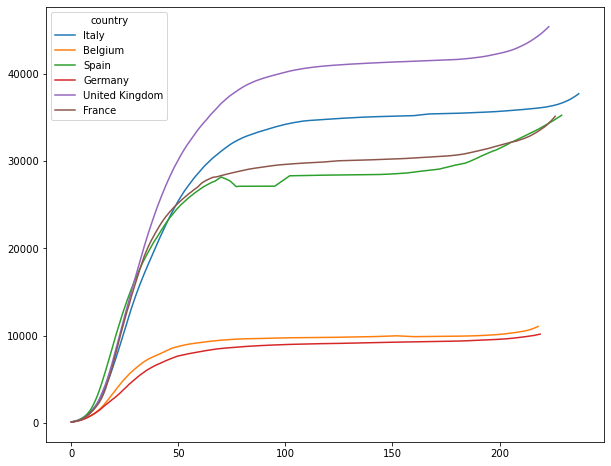

In [7]:
plt.rcParams.update({'font.size': 10, 'figure.figsize': (10, 8)}) # adjust font and plot size

df_smooth.plot()

In [8]:
def transform(df, fn):
    '''Applies an incremental transformation to the series.
    
    Keyword arguments:
    @df: input dataframe
    @fn: the incremental transformation
        
    Examples:
    fn=lambda x,y: x - y will get the daily increase
    fn=lambda x,y: (x - y)/y will get the daily relative increase
    fn = lambda x y: 1/log(x/y, 2) assuming an exponential increase, it will return the number of days to double the death count
    '''
    return df.apply(lambda line: [ fn(x,y) for (x,y) in (zip(line[1:], line))], result_type ='expand')

linear_increase = transform(df_smooth, lambda x, y: x - y)

## Daily rate increase - aka the curve!
starting from the day the 100th death was reported

rolling average over the past 7 days

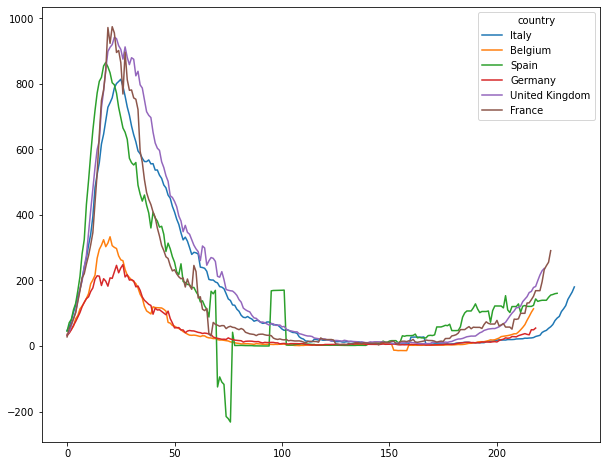

In [9]:
linear_increase.plot()

In [10]:
# rel_increase = transform(smoothened, lambda x, y: (x - y)/y if y >0 else None )
# rel_increase.plot()

## Number of day to double the death count - by country
**The higher the better, means the country is flattening the curve**

starting from the day the 100th death was reported

rolling average over the past 7 days

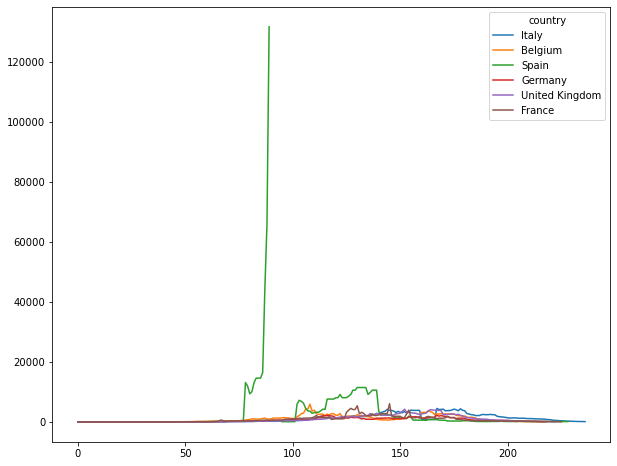

In [11]:
exp_increase = transform(df_smooth, lambda x, y: 1/log(x/y, 2) if y > 0 and x > y else None )
exp_increase.plot()

In [12]:
# df_n = normalized by population
df_n = df_smooth.copy()
for country in df_smooth:
    df_n[country] =  df_smooth[country] / (pop[country] / 10000)

df_n.tail()

country,Italy,Belgium,Spain,Germany,United Kingdom,France
233,6.137595,NaN,NaN,NaN,NaN,NaN
234,6.161120,NaN,NaN,NaN,NaN,NaN
235,6.186489,NaN,NaN,NaN,NaN,NaN
236,6.213774,NaN,NaN,NaN,NaN,NaN
237,6.243612,NaN,NaN,NaN,NaN,NaN


## Death normalized - by country (per 10000 ppl)
starting from the day the 100th death was reported

rolling average over the past 7 days

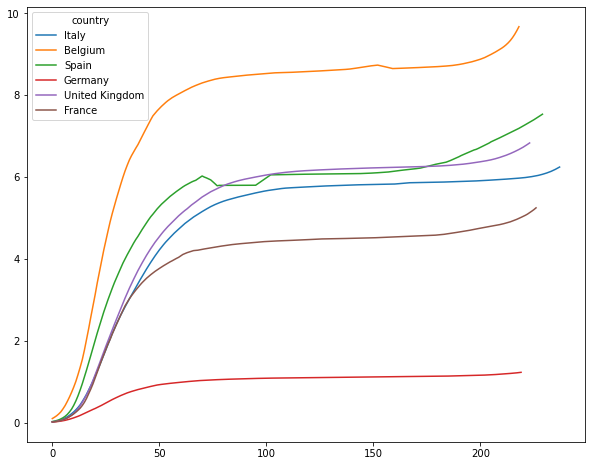

In [13]:
df_n.plot()

## Daily death normalized - by country (per 10000 ppl)
starting from the day the 100th death was reported

rolling average over the past 7 days

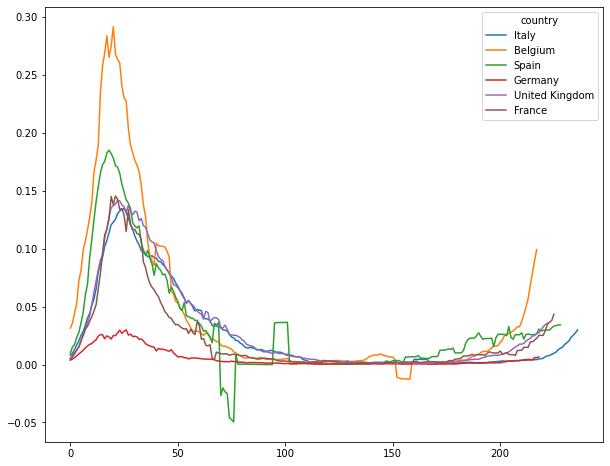

In [14]:
linear_increase_n = transform(df_n, lambda x, y: x - y)
linear_increase_n.plot()